# Metadata unification

Since the metadata of the datasets are not unified, it is necessary to unify them in order to be able to use them in the same way. Since this is the only year in the dataset, it doesn't make sense to try to create a python script to do this,

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import pandas_profiling

c:\Users\user\Deep Learning\melanoma-segmentation-and-classification\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\user\AppData\Local\Temp\ipykernel_16656\1888228696.py:7: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


## Metadata extraction

In [2]:
# Classification_GroundTruth

gt_training = pd.read_csv('../data/ISIC-2017_Training_Part3_GroundTruth.csv')
gt_validation = pd.read_csv('../data/ISIC-2017_Validation_Part3_GroundTruth.csv')

# Classification_Metadata
gt_training_metadata = pd.read_csv('../data/ISIC-2017_Training_Data/ISIC-2017_Training_Data_metadata.csv')
gt_validation_metadata = pd.read_csv('../data/ISIC-2017_Validation_Data/ISIC-2017_Validation_Data_metadata.csv')

## Generate Pandas Profiling Report

In [3]:
gt_training_discovery = gt_training.merge(gt_training_metadata, on='image_id')
gt_validation_discovery = gt_training.merge(gt_training_metadata, on='image_id')

# Generate a profile report of the data
def generate_profile_report(data, name):
    #Extract name from variable

    profile = pandas_profiling.ProfileReport(data)
    profile.to_file(f"profile_report_{name}.html")

generate_profile_report(gt_training_discovery, 'training')
generate_profile_report(gt_validation_discovery, 'validation')

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 333.04it/s]


Due to the nature of the training, it is not possible to leave the unknown values as they are. This may cause the model to be trained incorrectly. Therefore, it is necessary to make a decision about the unknown values. In this case, the unknown values will be deleted.

In [4]:
#Filter metadata of any 'unknown' in age_approximate or sex
gt_training_metadata['age_approximate'] = gt_training_metadata['age_approximate'].replace('unknown', '0')
gt_validation_metadata['age_approximate'] = gt_validation_metadata['age_approximate'].replace('unknown', '0')

gt_validation_metadata['sex'] = gt_validation_metadata['sex'].map({'unknown':-1,'female':0,'male':1})
gt_training_metadata['sex'] = gt_training_metadata['sex'].map({'unknown':-1,'female':0,'male':1})

#Cast age_approximate to int as well as melanoma
gt_training_metadata['age_approximate'] = round(gt_training_metadata['age_approximate'].astype(int)/90,4)
gt_validation_metadata['age_approximate'] = round(gt_validation_metadata['age_approximate'].astype(int)/90,4)
gt_training['melanoma'] = gt_training['melanoma'].astype(int)
gt_validation['melanoma'] = gt_validation['melanoma'].astype(int)

In [5]:
#Join left on gt_training_metadata
gt_training_merged = gt_training.merge(gt_training_metadata, how='right', on='image_id')
gt_validation_merged = gt_validation.merge(gt_validation_metadata, how='right', on='image_id')

In [6]:
generate_profile_report(gt_training_merged, 'training_merged')

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 332.75it/s]


In [7]:
#Check if dimensions are correct
print(gt_training.shape)
print(gt_validation.shape)

print(gt_training_metadata.shape)
print(gt_validation_metadata.shape)

print(gt_training_merged.shape)
print(gt_validation_merged.shape)


(2000, 3)
(150, 3)
(2000, 3)
(150, 3)
(2000, 5)
(150, 5)


In [8]:
#Delete columns that are not needed (seborrheic_keratosis)
gt_training_merged = gt_training_merged.drop(['seborrheic_keratosis'], axis=1)
gt_validation_merged = gt_validation_merged.drop(['seborrheic_keratosis'], axis=1)

#Check if columns are deleted
print(gt_training_merged.shape)
print(gt_validation_merged.shape)

(2000, 4)
(150, 4)


In [9]:
gt_training_merged.head()

,image_id,melanoma,age_approximate,sex
0,ISIC_0000000,0,0.6111,0
1,ISIC_0000001,0,0.3333,0
2,ISIC_0000002,1,0.6667,0
3,ISIC_0000003,0,0.3333,1
4,ISIC_0000004,1,0.8889,1


In [10]:
#Export to csv the final datasets
gt_training_merged.to_csv('../data/metadata/ISIC-2017_Training_Data.csv', index=False)
gt_validation_merged.to_csv('../data/metadata/ISIC-2017_Validation_Data.csv', index=False)

## Data exploration

In [11]:
# Analyze distributions
def analyze_and_plot(df, dataset_name):
    print(f"--- Analysis for {dataset_name} ---")
    print(df.describe(include='all'))

analyze_and_plot(gt_training_merged, 'training')


--- Analysis for training ---
            image_id     melanoma  age_approximate          sex
count           2000  2000.000000      2000.000000  2000.000000
unique          2000          NaN              NaN          NaN
top     ISIC_0015153          NaN              NaN          NaN
freq               1          NaN              NaN          NaN
mean             NaN     0.187000         0.475084     0.335500
std              NaN     0.390009         0.273963     0.672433
min              NaN     0.000000         0.000000    -1.000000
25%              NaN     0.000000         0.277800     0.000000
50%              NaN     0.000000         0.500000     0.000000
75%              NaN     0.000000         0.666700     1.000000
max              NaN     1.000000         0.944400     1.000000


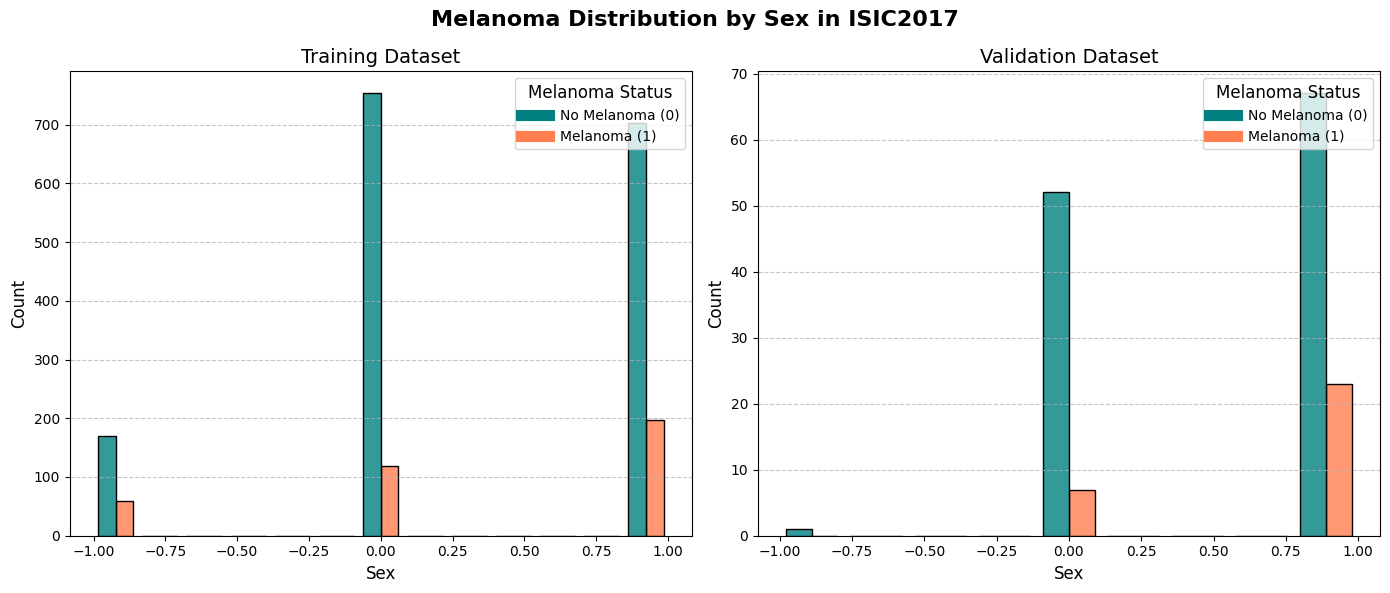

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of 'melanoma'
def plot_melanoma_distribution():
    # Define consistent colors for melanoma statuses
    custom_palette = {0: 'teal', 1: 'coral'}  # Teal for No Melanoma, Coral for Melanoma

    # Create separate plots for training and validation datasets
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Adjusted size to match age distribution plots
    fig.suptitle('Melanoma Distribution by Sex in ISIC2017', fontsize=16, weight='bold')
    # Training Dataset
    sns.histplot(
        data=gt_training_merged,
        x='sex',
        hue='melanoma',
        multiple="dodge",
        palette=custom_palette,
        shrink=0.8,
        alpha=0.8,  # Apply transparency
        ax=axes[0]
    )
    axes[0].set_title('Training Dataset', fontsize=14)
    axes[0].set_xlabel('Sex', fontsize=12)
    axes[0].set_ylabel('Count', fontsize=12)
    axes[0].grid(axis='y', linestyle='--', alpha=0.7)

    # Manually set the legend
    axes[0].legend(
        handles=[
            plt.Line2D([0], [0], color='teal', lw=8, label='No Melanoma (0)'),
            plt.Line2D([0], [0], color='coral', lw=8, label='Melanoma (1)')
        ],
        title='Melanoma Status',
        fontsize=10,
        title_fontsize=12,
        loc='upper right',
        frameon=True
    )

    # Validation Dataset
    sns.histplot(
        data=gt_validation_merged,
        x='sex',
        hue='melanoma',
        multiple="dodge",
        palette=custom_palette,
        shrink=0.8,
        alpha=0.8,  # Apply transparency
        ax=axes[1]
    )
    axes[1].set_title('Validation Dataset', fontsize=14)
    axes[1].set_xlabel('Sex', fontsize=12)
    axes[1].set_ylabel('Count', fontsize=12)
    axes[1].grid(axis='y', linestyle='--', alpha=0.7)

    # Manually set the legend
    axes[1].legend(
        handles=[
            plt.Line2D([0], [0], color='teal', lw=8, label='No Melanoma (0)'),
            plt.Line2D([0], [0], color='coral', lw=8, label='Melanoma (1)')
        ],
        title='Melanoma Status',
        fontsize=10,
        title_fontsize=12,
        loc='upper right',
        frameon=True
    )

    # Adjust layout
    plt.tight_layout()
    plt.show()

plot_melanoma_distribution()


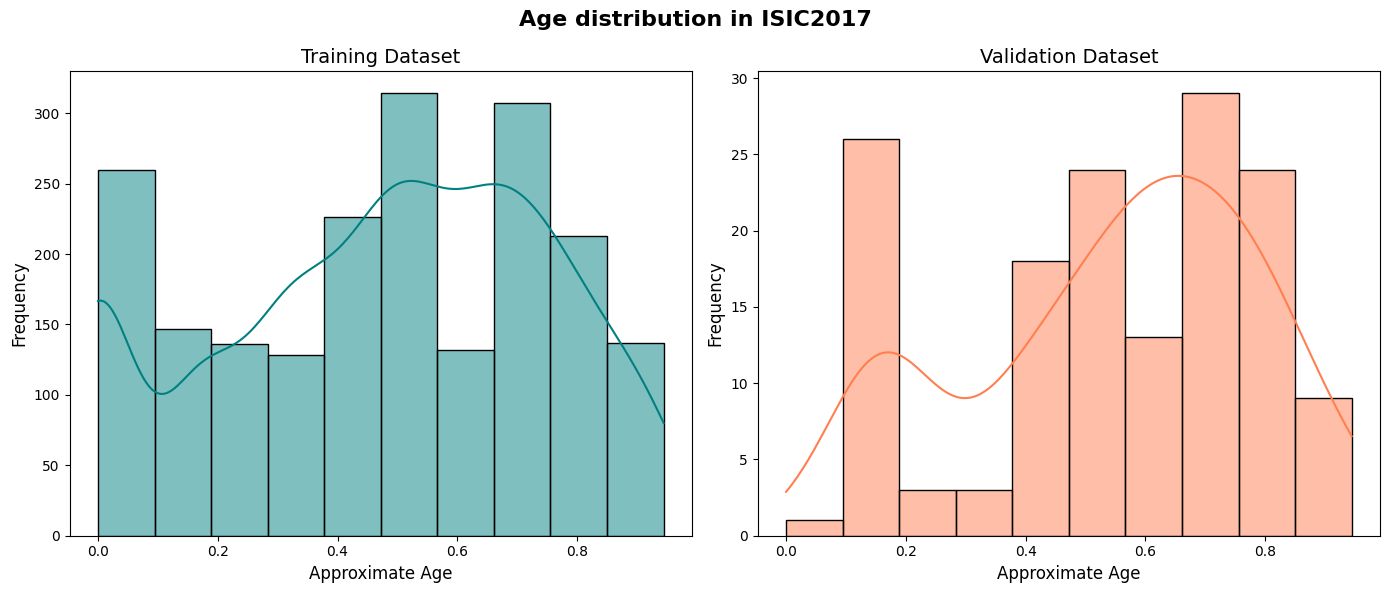

In [13]:
%matplotlib inline

# Ensure the data is sorted numerically by age
gt_training_merged = gt_training_merged.sort_values(by='age_approximate')
gt_validation_merged = gt_validation_merged.sort_values(by='age_approximate')

# Distribution of 'age_approximate'
def plot_age_distribution():
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle('Age distribution in ISIC2017', fontsize=16, weight='bold')
    # Training Dataset
    sns.histplot(data=gt_training_merged, x='age_approximate', kde=True, bins=10, ax=ax[0], color='teal')
    ax[0].set_title('Training Dataset', fontsize=14)
    ax[0].set_xlabel('Approximate Age', fontsize=12)
    ax[0].set_ylabel('Frequency', fontsize=12)
    
    # Validation Dataset
    sns.histplot(data=gt_validation_merged, x='age_approximate', kde=True, bins=10, ax=ax[1], color='coral')
    ax[1].set_title('Validation Dataset', fontsize=14)
    ax[1].set_xlabel('Approximate Age', fontsize=12)
    ax[1].set_ylabel('Frequency', fontsize=12)
    
    plt.tight_layout()
    plt.show()

plot_age_distribution()


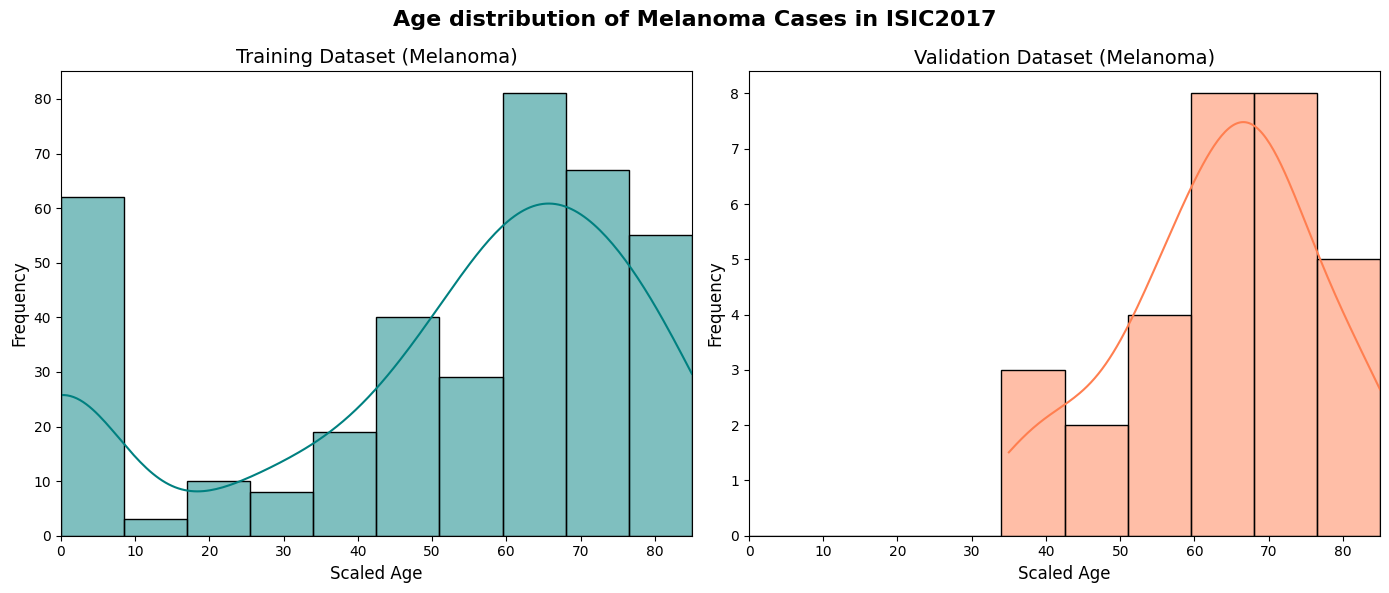

In [20]:
# Ensure the data is sorted numerically by age
gt_training_merged['age_scaled'] = (gt_training_merged['age_approximate'] * 90).round().astype(int)
gt_validation_merged['age_scaled'] = (gt_validation_merged['age_approximate'] * 90).round().astype(int)

# Filter datasets for melanoma cases

melanoma_training = gt_training_merged[gt_training_merged['melanoma'] == 1]
melanoma_validation = gt_validation_merged[gt_validation_merged['melanoma'] == 1]
# Get the common x-axis range
min_age = min(melanoma_training['age_scaled'].min(), melanoma_validation['age_scaled'].min())
max_age = max(melanoma_training['age_scaled'].max(), melanoma_validation['age_scaled'].max())

# Define a common set of bins
num_bins = 10  # You can adjust this value for more or fewer bars
bins = np.linspace(min_age, max_age, num_bins + 1)  # Ensure equal bin widths

# Distribution of 'age_scaled' for melanoma cases
def plot_melanoma_age_distribution_scaled():
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle('Age distribution of Melanoma Cases in ISIC2017', fontsize=16, weight='bold')
    
    # Training Dataset (Melanoma)
    sns.histplot(data=melanoma_training, x='age_scaled', kde=True, bins=bins, ax=ax[0], color='teal')
    ax[0].set_title('Training Dataset (Melanoma)', fontsize=14)
    ax[0].set_xlabel('Scaled Age', fontsize=12)
    ax[0].set_ylabel('Frequency', fontsize=12)
    ax[0].set_xlim(min_age, max_age)  # Set common x-axis limits
    
    # Validation Dataset (Melanoma)
    sns.histplot(data=melanoma_validation, x='age_scaled', kde=True, bins=bins, ax=ax[1], color='coral')
    ax[1].set_title('Validation Dataset (Melanoma)', fontsize=14)
    ax[1].set_xlabel('Scaled Age', fontsize=12)
    ax[1].set_ylabel('Frequency', fontsize=12)
    ax[1].set_xlim(min_age, max_age)  # Set common x-axis limits
    
    plt.tight_layout()
    plt.show()

plot_melanoma_age_distribution_scaled()


In [15]:

# Summarize data for LaTeX table
def summarize_for_latex():
    summary = pd.DataFrame({
        'Metric': ['Total Images', 'Melanoma (1)', 'Melanoma (0)', 'Mean Age', 'Median Age'],
        'Training Dataset': [
            len(gt_training_merged),
            gt_training_merged['melanoma'].sum(),
            (gt_training_merged['melanoma'] == 0).sum(),
            gt_training_merged['age_approximate'].astype(int).mean(),
            gt_training_merged['age_approximate'].astype(int).median()
        ],
        'Validation Dataset': [
            len(gt_validation_merged),
            gt_validation_merged['melanoma'].sum(),
            (gt_validation_merged['melanoma'] == 0).sum(),
            gt_validation_merged['age_approximate'].astype(int).mean(),
            gt_validation_merged['age_approximate'].astype(int).median()
        ]
    })
    return summary

summarize_for_latex()


,Metric,Training Dataset,Validation Dataset
0,Total Images,2000.0,150.0
1,Melanoma (1),374.0,30.0
2,Melanoma (0),1626.0,120.0
3,Mean Age,0.0,0.0
4,Median Age,0.0,0.0
